In [1]:
from glob import glob
import json
import os
import sys
import time

import matplotlib.pyplot as plt
import mne
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib qt

#### Plot electrodes

## Functions

In [5]:
def peaks_to_events(test_signal, test_time, peak_threshold):
    pks, pks_info = signal.find_peaks(test_signal, peak_threshold)
    peak_times = test_time[pks]
    pk_preISIs = np.insert(np.diff(peak_times), 0, peak_times[0] - test_time[0])
    ## Loop through all peaks to find possible events ##
    event_list = []
    pkind = 0
    while pkind < len(peak_times):
        tempevent = [peak_times[pkind]]
        pkind += 1
        while (pkind < len(pk_preISIs)) and (pk_preISIs[pkind] < 0.4):
            tempevent.append(peak_times[pkind])
            pkind += 1
        if len(tempevent) > 1:
            event_list.append(tempevent)
        del tempevent
    return event_list
    

def annotate_SWDs(EEGsignal_exch, EEGtime, samplerate, filtfreqs=[3, 50], testslice=[0, 300]):
    ## Apply a bandpass filter to the whole signal ##
    bpb, bpa = signal.butter(3, np.array(filtfreqs)/(samplerate/2), btype='bandpass')
    filt_data = signal.filtfilt(bpb, bpa, EEGsignal_exch, axis=0)
    
    ## Start by using testslice to define a temporary threshold ##
    ## Identify possible SWDs so we can use quiescent times to define a better spike detection threshold ##
    slice_inds = np.nonzero((EEGtime > EEGtime[0] + testslice[0]) & (EEGtime < EEGtime[0] + testslice[1]))[0]
    timex = EEGtime[slice_inds]
    filtslice = filt_data[slice_inds]
    print('First threshold: {:.2f} mV'.format(np.mean(filtslice) + 2 * np.std(filtslice)))
    temp_event_list = peaks_to_events(-filtslice, timex, peak_threshold=np.mean(filtslice) + 2 * np.std(filtslice))
    ## Get quiescent times ##
    prob_events = []
    for evlist in temp_event_list:
        prob_events.append([evlist[0], evlist[-1]])
    prob_events_df = pd.DataFrame(prob_events, columns=['onset', 'offset'])
    
    ## Next, get quiescent times and more strict threshold ##
    adj_onsets = prob_events_df['onset'].values - 1
    adj_offsets = prob_events_df['offset'].values + 1
    qints = np.nonzero((adj_onsets[1:] - adj_offsets[:-1]) > 2)[0]
    qsigs = []
    for indi in qints:
        tempinds = np.nonzero((timex > adj_offsets[indi]) & (timex < adj_onsets[indi+1]))[0]
        qsigs.append(filtslice[tempinds])
    qeeg = np.concatenate(qsigs)
    
    ## Identify events using new threshold ##
    print('Second threshold: {:.2f} mV'.format(np.mean(qeeg) + 3 * np.std(qeeg)))
    new_event_list = peaks_to_events(-filt_data, EEGtime, peak_threshold=np.mean(qeeg) + 3 * np.std(qeeg))
    SWD_info = []
    for spklist in new_event_list:
        if spklist[-1] - spklist[0] > 0.5:
            SWD_info.append([spklist[0], spklist[-1], spklist[-1]-spklist[0], len(spklist), spklist])
    SWD_df = pd.DataFrame(SWD_info, columns=['onset', 'offset', 'duration', 'spike_count', 'SWD_spike_times'])
    print('Found {:d} SWD events.'.format(len(SWD_df)))
    return SWD_df

### Load experiment

In [6]:
recfolder = r'E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_estim_2023-07-13_13-28-01\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [7]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


In [8]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('{} already exists, change name or overwrite existing.'.format(auto_annot_file))

E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_estim_2023-07-13_13-28-01\experiment1\recording1\autoSWDs_v1.pkl already exists, change name or overwrite existing.


### Load EEG data

In [9]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [10]:
print(eeg_ts[0])
print(eeg_ts[-1])
print(len(eeg_ts))

79.3536544827942
6682.103505585035
16506880


Load manual annotations, too

### Get SWDs from auto annotation

In [11]:
ex_ch = 18
start = time.time()
autoSWD_df = annotate_SWDs(
    eeg_data[:,ex_ch], eeg_ts, samplerate=exp.ephys_params['EEG']['sample_rate'], filtfreqs=[3, 50], testslice=[0, 800]
)
end = time.time()
print('Time for auto detection: {:.1f} s'.format(end-start))

First threshold: 0.54 mV
Second threshold: 0.67 mV
Found 1104 SWD events.
Time for auto detection: 0.7 s


In [12]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,79.485654,80.623250,1.137596,8,"[79.48565397127203, 79.61285347835067, 79.7696..."
1,86.240428,87.446023,1.205595,8,"[86.24042779528774, 86.56242654748367, 86.7428..."
2,88.460819,90.632411,2.171592,13,"[88.46081919086488, 88.62561855223721, 88.9544..."
3,102.490765,103.025563,0.534798,3,"[102.49076482225891, 102.83996346905028, 103.0..."
4,105.004355,106.345150,1.340795,7,"[105.00435508163683, 105.35155373617852, 105.5..."


### Create MNE Raw object and plot annotated SWDs

In [13]:
ch_names = [str(x) for x in eeg_chs]
info = mne.create_info(ch_names=ch_names, sfreq=exp.ephys_params['EEG']['sample_rate'], ch_types='eeg')
# can add bad channels to info

In [14]:
mne_raw = mne.io.RawArray(eeg_data.T[eeg_chs,:]*1e-3, info)
# for mne.io.RawArray, eeg channels must be in Volts

Creating RawArray with float64 data, n_channels=30, n_times=16506880
    Range : 0 ... 16506879 =      0.000 ...  6602.752 secs
Ready.


#### Set annotations

In [15]:
my_annot = mne.Annotations(
    onset=autoSWD_df['onset'].values - eeg_ts[0], # onset in s, corrected to align with time zero
    duration=autoSWD_df['duration'].values,
    description=['SWDa'] * len(autoSWD_df)
)

In [16]:
mne_raw.set_annotations(my_annot)
print(mne_raw.annotations)

<Annotations | 1104 segments: SWDa (1104)>


#### Plot to check them

Using matplotlib as 2D backend.


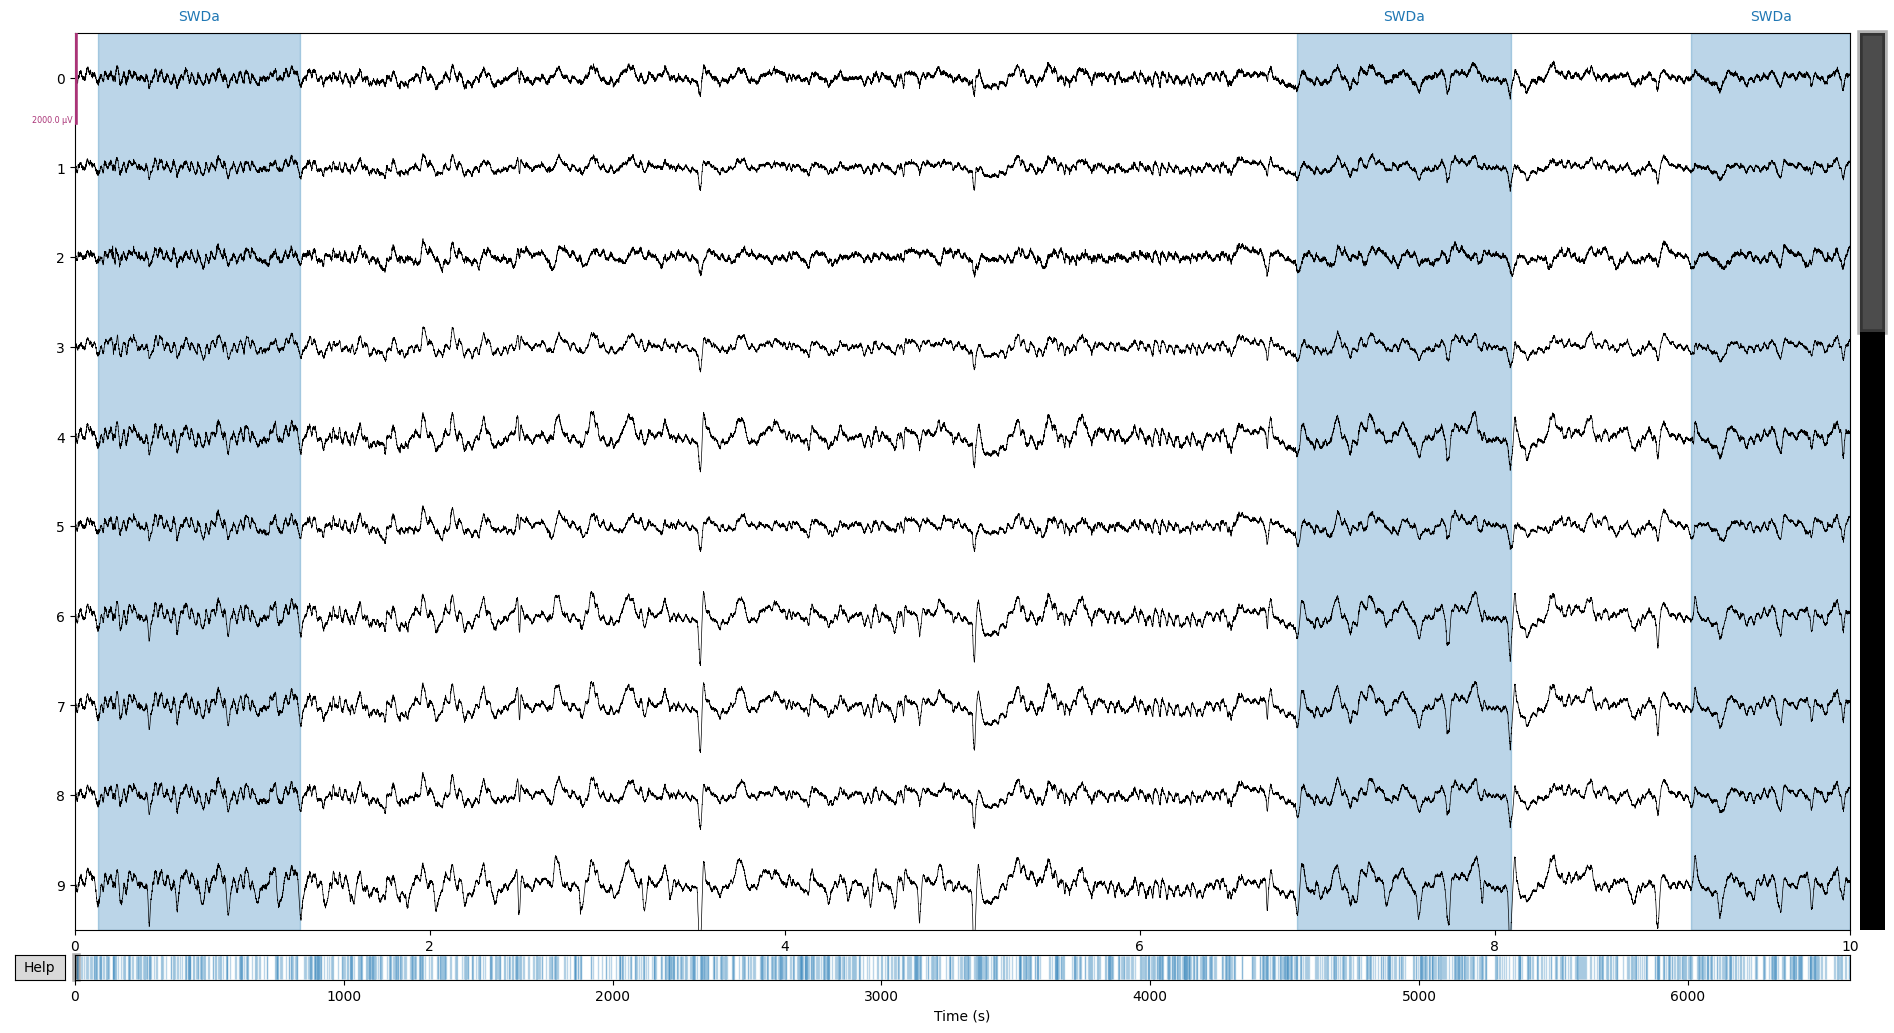

Channels marked as bad:
none


In [17]:
scalings = {'eeg': 1e-3}
mne_raw.plot(n_channels=10, scalings=scalings)

Hmm, not performing as well as I thought...misses some short events and is really sensitive to spikes before the SWD, so it may be miss identifying the start time.

### Save auto annotations as a pickle file

In [13]:
autoSWD_df.to_pickle(auto_annot_file)
print('Saved {}'.format(auto_annot_file))

Saved E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_estim_2023-07-05_12-39-59\experiment1\recording1\autoSWDs_v1.pkl


### Plot manual vs. auto detections

In [21]:
bpb, bpa = signal.butter(3, np.array([3, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data[:, ex_ch], axis=0)

In [25]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.plot(eeg_ts, filt_data, color='k', linewidth=1.0)
ax.set_xlim([eeg_ts[0], 445])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, SWDs'.format(exp.mouse, exp_tag))

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)
    
for swdind, swdrow in autoSWD_df.iterrows():
    ax.axvspan(swdrow['onset'], swdrow['offset'], 0, 0.5, color='g', alpha=0.2)
fig.show()